In [1]:
import cltk
import medlatin
import bcubed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from tqdm.notebook import tqdm

In [2]:
#!pip install cltk
#!pip install pip==21.3.1
#!pip install bcubed

## Generating style vectors from the reduced Medlatin1 dataset

In [3]:
lat_cltk = cltk.NLP(language='lat', suppress_banner=True)
# remove process since it slows the code (it adds definitions to each word)
lat_cltk.pipeline.processes.remove(cltk.lexicon.processes.LatinLexiconProcess)
# remove process since it slows the code (it generates word2vec embeddings)
lat_cltk.pipeline.processes.remove(cltk.embeddings.processes.LatinEmbeddingsProcess)

In [4]:
medlatin1_path = '../MedLatin/Corpora/MedLatinEpi'

medlatin1_texts, medlatin1_authors, medlatin_titles = medlatin.load_medlatin(medlatin1_path)

In [5]:
author_changes_idx = [i for i in range(len(medlatin1_authors)) if medlatin1_authors[i-1] != medlatin1_authors[i]]
author_changes_names = [medlatin1_authors[i] for i in author_changes_idx]
# Clara, and Misc have too few texts and they mess with the clustering
# let's try running the experiments without their texts to see the results
from_dante_idx = author_changes_idx[author_changes_names.index('Dante')]
to_misc_idx = author_changes_idx[author_changes_names.index('Misc')]
from_vigna_idx = author_changes_idx[author_changes_names.index('PierDellaVigna')]

In [6]:
# this results in 260 texts
medlatin1_texts = medlatin1_texts[from_dante_idx:to_misc_idx] + medlatin1_texts[from_vigna_idx:]

In [7]:
author_changes_idx = author_changes_idx[author_changes_names.index('Dante'):author_changes_names.index('Misc')+1]
author_changes_idx = [i - from_dante_idx for i in author_changes_idx]
author_changes_names = ['Dante', 'GiovanniBoccaccio', 'GuidoFaba', 'PierDellaVigna']

In [8]:
# these lists of lists contain POS-tags, embeddings and tokens for each text in the dataset
medlatin1_pos, medlatin1_emb, medlatin1_tokens = medlatin.generate_text_vectors(medlatin1_texts, lat_cltk)

  0%|          | 0/260 [00:00<?, ?it/s]

/home/johanneshermannpalboel/thesis/BoB-thesis/.venv/lib/python3.11/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'la_core_web_lg' (3.7.7) was trained with spaCy v3.7.5 and may not be 100% compatible with the current version (3.7.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Unrecognized value 'Perf' for UD feature 'Tense'.
If you believe this is not an error in the dependency parser, please raise an issue at <https://github.com/cltk/cltk/issues> and include a short text to reproduce the error.

Unrecognized value 'Perf' for UD feature 'Tense'.
If you believe this is not an error in the dependency parser, please raise an issue at <https://github.com/cltk/cltk/issues> and include a short text to reproduce the error.

Unrecognized value 'Perf' for UD feature 'Tense'.
If you believe this is not an error in the dependency parser, please raise an issue at <https://github.com/cltk/cltk/issues> and include a short text to reproduce the error.

Unrecognized value 'Perf' for UD feature 'Tense'.
If you believe this is not an error in the dependency parser, please raise an issue at <https://github.com/cltk/cltk/issues> and include a short text to reproduce the error.

Unrecognized value 'Perf' for UD feature 'Tense'.
If you believe this is not an error in the depende

In [9]:
medlatin1_tokens_counter= medlatin.token_counter(medlatin1_tokens)
# we don't want to count punctuation among the most common tokens
stop_list = [',', '.', '', ';', ':']
medlatin1_most_common_tokens = medlatin.get_common_tokens(medlatin1_tokens_counter, n=20, stop_list=stop_list)

In [10]:
with open('csvfiles/most_common_tokens.txt', 'w', encoding='utf-8') as f:
    for token in medlatin1_most_common_tokens:
        f.write(f'{token}\n')

In [11]:
# this combines the lists of POS-tags and tokens so that the most common tokens
# are left as is while other tokens are replaced by their POS-tags
medlatin1_combined_pos_tokens = medlatin.combine_pos_most_common_tokens(medlatin1_tokens,
                                                                        medlatin1_pos,
                                                                        medlatin1_most_common_tokens)

In [12]:
word_tfidf = medlatin.word_tfidf(medlatin1_combined_pos_tokens)
char_tfidf = medlatin.char_tfidf(medlatin1_tokens)
# this combines the word based and character based TF-IDF matrices so that we have a
# new matrix of shape (len(texts), word_tfidf.shape[1]+char_tfidf.shape[1])
medlatin_tfidf = np.append(word_tfidf.toarray(), char_tfidf.toarray(), axis=1)
# we have to take the mean of each text's word embeddings to get one embedding per text
#medlatin1_emb_mean = [np.array(embeddings).mean(axis=0) for embeddings in medlatin1_emb]
#medlatin1_emb_mean = np.array(medlatin1_emb_mean)

In [13]:
# saving the default style vectors to a csv file (n=2, r=100)
#np.savetxt('csvfiles/tfidf_n2_r100.csv', medlatin_tfidf, delimiter=',')
# saving the embeddings to a csv file (they do not depend on rank or ngram size)
#np.savetxt('csvfiles/embeddings.csv', medlatin1_emb_mean, delimiter=',')

# saving the author names
with open('csvfiles/author_changes_names.txt', 'w', encoding='utf-8') as f:
    for name in author_changes_names:
        f.write(f'{name}\n')

# saving the indices where the authors change
with open('csvfiles/author_changes_idx.txt', 'w', encoding='utf-8') as f:
    for i in author_changes_idx:
        f.write(f'{i}\n')

### Trying different rank (max_feats) and ngram hyperparameters

In [14]:
ngrams_list = [2, 3, 4]
ranks_list = [100, 200, 300]
tfidf_dict = {}
for ngram in ngrams_list:
    tfidf_dict[ngram] = {}
    for rank in ranks_list:
        word_tfidf = medlatin.word_tfidf(medlatin1_combined_pos_tokens, ngrams=ngram, max_feats=rank)
        char_tfidf = medlatin.char_tfidf(medlatin1_tokens, ngrams=ngram, max_feats=rank)
        word_char_tfidf = np.append(word_tfidf.toarray(), char_tfidf.toarray(), axis=1)
        tfidf_dict[ngram][rank] = word_char_tfidf

In [15]:
for ngram in tfidf_dict:
    for rank in tfidf_dict[ngram]:
        np.savetxt(f'csvfiles/tfidf_n{ngram}_r{rank}.csv', tfidf_dict[ngram][rank], delimiter=',')

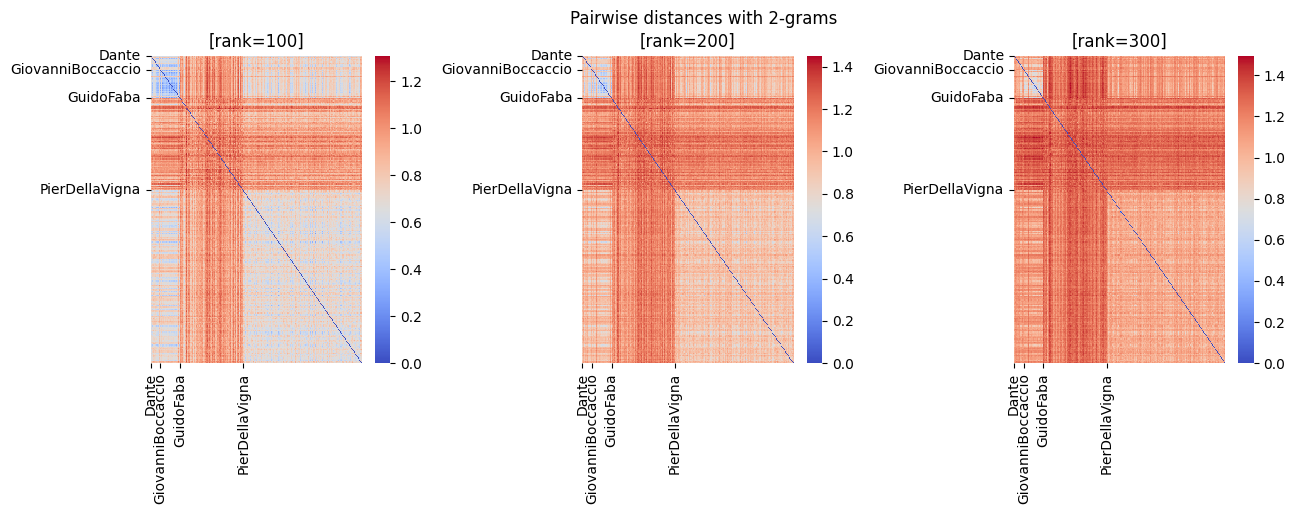

In [16]:
n = 2
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
fig.suptitle(f'Pairwise distances with {n}-grams')
plt.tight_layout(w_pad=9)

for idx, ax in enumerate(axes.reshape(-1)):
    sns.heatmap(pairwise_distances(tfidf_dict[n][ranks_list[idx]]), cmap='coolwarm', ax=ax)
    ax.set_title(f'[rank={ranks_list[idx]}]')
    ax.set_yticks(author_changes_idx)
    ax.set_yticklabels(author_changes_names)
    ax.set_xticks(author_changes_idx)
    ax.set_xticklabels(author_changes_names)

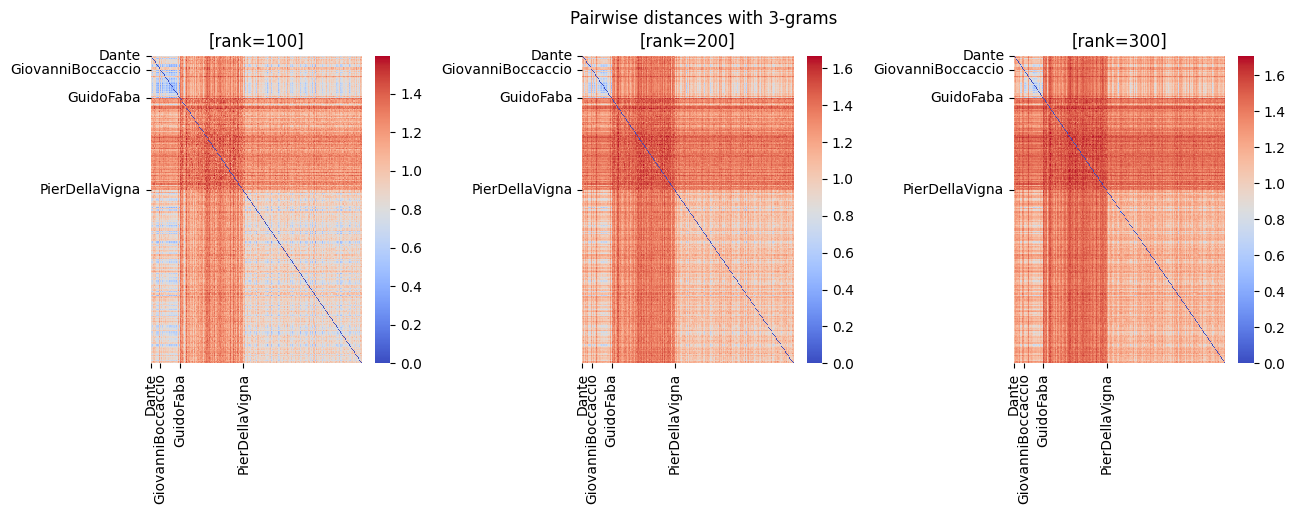

In [17]:
n = 3
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
fig.suptitle(f'Pairwise distances with {n}-grams')
plt.tight_layout(w_pad=9)

for idx, ax in enumerate(axes.reshape(-1)):
    sns.heatmap(pairwise_distances(tfidf_dict[n][ranks_list[idx]]), cmap='coolwarm', ax=ax)
    ax.set_title(f'[rank={ranks_list[idx]}]')
    ax.set_yticks(author_changes_idx)
    ax.set_yticklabels(author_changes_names)
    ax.set_xticks(author_changes_idx)
    ax.set_xticklabels(author_changes_names)

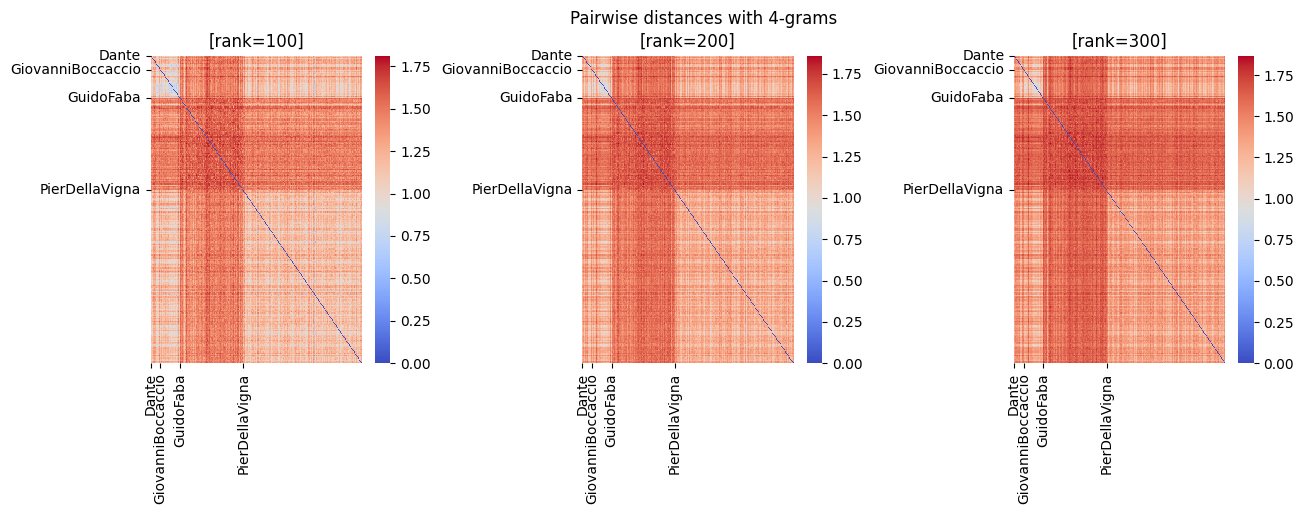

In [18]:
n = 4
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
fig.suptitle(f'Pairwise distances with {n}-grams')
plt.tight_layout(w_pad=9)

for idx, ax in enumerate(axes.reshape(-1)):
    sns.heatmap(pairwise_distances(tfidf_dict[n][ranks_list[idx]]), cmap='coolwarm', ax=ax)
    ax.set_title(f'[rank={ranks_list[idx]}]')
    ax.set_yticks(author_changes_idx)
    ax.set_yticklabels(author_changes_names)
    ax.set_xticks(author_changes_idx)
    ax.set_xticklabels(author_changes_names)

In [19]:
# there are four different authors in the reduced set of texts
n_authors = len(author_changes_names)
kmean_dict = {}
for ngram in tfidf_dict:
    kmean_dict[ngram] = {}
    for rank in tfidf_dict[ngram]:
        kmean_dict[ngram][rank] = medlatin.repeat_kmeans(tfidf_dict[ngram][rank], clusters=n_authors)
        # for i in range(100):
        #     kmeans_tfidf = KMeans(n_clusters=n_authors, n_init='auto').fit(word_char_tfidf)
        #     #kmeans_emb = KMeans(n_clusters=n_authors, n_init='auto').fit(medlatin1_emb_mean)
        #     kmean_dict[ngram][rank].append(kmeans_tfidf.labels_)
        #     #kmean_100_emb.append(kmeans_emb.labels_)

        # kmean_dict[ngram][rank] = np.array(kmean_dict[ngram][rank])

### Bcubed

Python package: https://github.com/hhromic/python-bcubed

Paper on author clustering: https://repository.uantwerpen.be/docman/irua/48ca6d/139273.pdf

In [20]:
y = np.zeros(medlatin_tfidf.shape[0], dtype=int)
y[author_changes_idx[0]:author_changes_idx[1]] = 0
y[author_changes_idx[1]:author_changes_idx[2]] = 1
y[author_changes_idx[2]:author_changes_idx[3]] = 2
y[author_changes_idx[3]:] = 3

In [21]:
ldict = {idx: set([author_changes_names[val]]) for idx, val in enumerate(y)}

In [22]:
multi_index = pd.MultiIndex.from_product([['precision', 'recall', 'fscore'], ngrams_list], names=["bcubed_measure", "ngram"])
bcubed_df = pd.DataFrame(index=multi_index, columns=ranks_list)

In [23]:
for ngram in tqdm(kmean_dict):
    for rank in tqdm(kmean_dict[ngram]):
        for clustering in kmean_dict[ngram][rank]:
            cdict = {idx: set([val]) for idx, val in enumerate(clustering)}

            precision = bcubed.precision(cdict, ldict)
            recall = bcubed.recall(cdict, ldict)
            fscore = bcubed.fscore(precision, recall)

            bcubed_df.loc[('precision', ngram), rank] = precision
            bcubed_df.loc[('recall', ngram), rank] = recall
            bcubed_df.loc[('fscore', ngram), rank] = fscore

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [24]:
bcubed_df

100       200       300
bcubed_measure ngram                              
precision      2      0.803317  0.819023  0.847054
               3      0.725463  0.734642  0.749963
               4      0.770012  0.794172  0.734256
recall         2       0.58842  0.627783   0.75465
               3      0.825355  0.907469  0.864793
               4      0.602001  0.641762  0.913432
fscore         2      0.679278  0.710764  0.798187
               3      0.772192  0.811961  0.803295
               4       0.67572  0.709879  0.814102

In [25]:
bcubed_df.T.mean()

bcubed_measure  ngram
precision       2        0.823132
                3        0.736689
                4        0.766147
recall          2        0.656951
                3        0.865873
                4        0.719065
fscore          2        0.729409
                3        0.795816
                4        0.733234
dtype: object

In [26]:
bcubed_df.loc['precision'].mean()

100    0.766264
200    0.782613
300    0.777091
dtype: object

In [27]:
bcubed_df.loc['recall'].mean()

100    0.671926
200    0.725672
300    0.844292
dtype: object

In [28]:
bcubed_df.loc['fscore'].mean()

100    0.709063
200    0.744201
300    0.805195
dtype: object